In [1]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import VAR
from scipy.stats import pearsonr
import xgboost as xgb
import gc

# Data import

In [2]:
trivialdata = pd.read_csv("sample_submission.csv")
traindata = pd.read_csv("train.csv")
air_resr_data = pd.read_csv("MetaData/air_reserve.csv")
air_stor_data = pd.read_csv("MetaData/air_store_info.csv")
dte_info_data = pd.read_csv("MetaData/date_info.csv")
hpg_resr_data = pd.read_csv("MetaData/hpg_reserve.csv")
hpg_resr_data1 = pd.read_csv("MetaData/hpg_reserve.csv")
hpg_stor_data = pd.read_csv("MetaData/hpg_store_info.csv")
sto_reln_data = pd.read_csv("MetaData/store_id_relation.csv")

In [3]:
#trivialdata.count()

In [4]:
hpg_resr_data1['reserve_datetime'] = pd.to_datetime(hpg_resr_data1['reserve_datetime']).dt.date
hpg_resr_data1['visit_datetime'] = pd.to_datetime(hpg_resr_data1['visit_datetime']).dt.date
hpg_resr_data1['check_datetime'] =np.where((hpg_resr_data1['reserve_datetime'] != hpg_resr_data1['visit_datetime']) ,'diff date', 'same date')
hpg_resr_data1.groupby('check_datetime').count()
#out of 20M records, 18M has diff dates, 2M has same dates. hence visit_datetime & reserve_datetime has different data so can't remove one of the datetime column

,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors
check_datetime,,,,
diff date,1812112,1812112,1812112,1812112
same date,188208,188208,188208,188208


In [5]:
merge_hpg_resr_sto_reln = pd.merge(hpg_resr_data,sto_reln_data,how='left')
merge_hpg_resr_sto_reln

,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors,air_store_id
0,hpg_c63f6f42e088e50f,2016-01-01 11:00:00,2016-01-01 09:00:00,1,NaN
1,hpg_dac72789163a3f47,2016-01-01 13:00:00,2016-01-01 06:00:00,3,NaN
2,hpg_c8e24dcf51ca1eb5,2016-01-01 16:00:00,2016-01-01 14:00:00,2,NaN
3,hpg_24bb207e5fd49d4a,2016-01-01 17:00:00,2016-01-01 11:00:00,5,NaN
4,hpg_25291c542ebb3bc2,2016-01-01 17:00:00,2016-01-01 03:00:00,13,NaN
...,...,...,...,...,...
2000315,hpg_2b293477ea4642fb,2017-05-31 20:00:00,2017-04-19 07:00:00,2,NaN
2000316,hpg_f922aeca48ca5a29,2017-05-31 20:00:00,2017-03-19 00:00:00,3,NaN
2000317,hpg_e9151de687b93aa3,2017-05-31 21:00:00,2017-04-14 20:00:00,49,NaN
2000318,hpg_fae6c96189b4a122,2017-05-31 21:00:00,2017-04-19 17:00:00,9,NaN


In [6]:
print(sto_reln_data.shape)
print(hpg_resr_data.shape)
print(merge_hpg_resr_sto_reln.shape)

(150, 2)
(2000320, 4)
(2000320, 5)


In [7]:
#1972137 with null & 28183 with not null air_store_ids
merge_hpg_resr_sto_reln1=merge_hpg_resr_sto_reln.loc[merge_hpg_resr_sto_reln.air_store_id.notnull(),['air_store_id','visit_datetime','reserve_datetime','reserve_visitors']]
merge_hpg_resr_sto_reln1

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors
103,air_db80363d35f10926,2016-01-01 19:00:00,2016-01-01 15:00:00,4
121,air_08cb3c4ee6cd6a22,2016-01-01 19:00:00,2016-01-01 16:00:00,2
272,air_6b15edd1b4fbb96a,2016-01-02 17:00:00,2016-01-01 22:00:00,3
348,air_37189c92b6c761ec,2016-01-02 18:00:00,2016-01-02 17:00:00,2
349,air_37189c92b6c761ec,2016-01-02 18:00:00,2016-01-01 20:00:00,2
...,...,...,...,...
1999771,air_97159fc4e90053fe,2017-05-26 18:00:00,2017-04-11 08:00:00,2
1999798,air_db1233ad855b34d5,2017-05-26 19:00:00,2017-04-17 21:00:00,3
2000092,air_cb7467aed805e7fe,2017-05-27 19:00:00,2017-04-09 21:00:00,2
2000095,air_6b15edd1b4fbb96a,2017-05-27 19:00:00,2017-04-13 13:00:00,6


In [8]:
concat_hpg_resr_sto_reln1_air_resr=pd.concat([air_resr_data,merge_hpg_resr_sto_reln1])
concat_hpg_resr_sto_reln1_air_resr#120561 total air store ids

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5
...,...,...,...,...
1999771,air_97159fc4e90053fe,2017-05-26 18:00:00,2017-04-11 08:00:00,2
1999798,air_db1233ad855b34d5,2017-05-26 19:00:00,2017-04-17 21:00:00,3
2000092,air_cb7467aed805e7fe,2017-05-27 19:00:00,2017-04-09 21:00:00,2
2000095,air_6b15edd1b4fbb96a,2017-05-27 19:00:00,2017-04-13 13:00:00,6


In [9]:
print(merge_hpg_resr_sto_reln1.shape)
print(air_resr_data.shape)
print(concat_hpg_resr_sto_reln1_air_resr.shape)


(28183, 4)
(92378, 4)
(120561, 4)


In [10]:

concat_hpg_resr_sto_reln1_air_resr.sort_values(['air_store_id','visit_datetime','reserve_datetime','reserve_visitors'], inplace = True) 
bool_series = concat_hpg_resr_sto_reln1_air_resr[['air_store_id','visit_datetime','reserve_datetime','reserve_visitors']].duplicated(keep = False)  
bool_series 
concat_hpg_resr_sto_reln1_air_resr = concat_hpg_resr_sto_reln1_air_resr[~bool_series] 
concat_hpg_resr_sto_reln1_air_resr#106288

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors
18127,air_00a91d42b08b08d9,2016-01-14 19:00:00,2016-01-11 14:00:00,2
19734,air_00a91d42b08b08d9,2016-01-15 18:00:00,2016-01-09 20:00:00,4
24457,air_00a91d42b08b08d9,2016-01-16 18:00:00,2016-01-13 20:00:00,2
35967,air_00a91d42b08b08d9,2016-01-22 18:00:00,2016-01-19 08:00:00,2
54765,air_00a91d42b08b08d9,2016-01-29 18:00:00,2016-01-23 18:00:00,5
...,...,...,...,...
89029,air_fea5dc9594450608,2017-04-20 18:00:00,2017-04-17 18:00:00,6
89482,air_fea5dc9594450608,2017-04-21 18:00:00,2017-04-03 18:00:00,6
89643,air_fea5dc9594450608,2017-04-21 19:00:00,2017-04-12 20:00:00,2
47839,air_fee8dcf4d619598e,2017-01-09 19:00:00,2016-12-27 14:00:00,2


In [11]:
air_store=air_stor_data.drop(['air_area_name'], axis=1)
air_store

,air_store_id,air_genre_name,latitude,longitude
0,air_0f0cdeee6c9bf3d7,Italian/French,34.695124,135.197852
1,air_7cc17a324ae5c7dc,Italian/French,34.695124,135.197852
2,air_fee8dcf4d619598e,Italian/French,34.695124,135.197852
3,air_a17f0778617c76e2,Italian/French,34.695124,135.197852
4,air_83db5aff8f50478e,Italian/French,35.658068,139.751599
...,...,...,...,...
824,air_9bf595ef095572fb,International cuisine,35.661777,139.704051
825,air_764f71040a413d4d,Asian,35.661777,139.704051
826,air_10bbe8acd943d8f6,Asian,35.661777,139.704051
827,air_7514d90009613cd6,Karaoke/Party,43.055460,141.340956


In [12]:
onehot_air_genre=pd.get_dummies(air_store.air_genre_name)
merge_air_store_genre = pd.concat([air_store,onehot_air_genre], axis='columns')
merge_air_store_genre1 =merge_air_store_genre.drop(['air_genre_name','Yakiniku/Korean food'], axis=1)
merge_air_store_genre1

,air_store_id,latitude,longitude,Asian,Bar/Cocktail,Cafe/Sweets,Creative cuisine,Dining bar,International cuisine,Italian/French,Izakaya,Japanese food,Karaoke/Party,Okonomiyaki/Monja/Teppanyaki,Other,Western food
0,air_0f0cdeee6c9bf3d7,34.695124,135.197852,0,0,0,0,0,0,1,0,0,0,0,0,0
1,air_7cc17a324ae5c7dc,34.695124,135.197852,0,0,0,0,0,0,1,0,0,0,0,0,0
2,air_fee8dcf4d619598e,34.695124,135.197852,0,0,0,0,0,0,1,0,0,0,0,0,0
3,air_a17f0778617c76e2,34.695124,135.197852,0,0,0,0,0,0,1,0,0,0,0,0,0
4,air_83db5aff8f50478e,35.658068,139.751599,0,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
824,air_9bf595ef095572fb,35.661777,139.704051,0,0,0,0,0,1,0,0,0,0,0,0,0
825,air_764f71040a413d4d,35.661777,139.704051,1,0,0,0,0,0,0,0,0,0,0,0,0
826,air_10bbe8acd943d8f6,35.661777,139.704051,1,0,0,0,0,0,0,0,0,0,0,0,0
827,air_7514d90009613cd6,43.055460,141.340956,0,0,0,0,0,0,0,0,0,1,0,0,0


In [13]:
merge_air_store_genre2 = pd.merge(concat_hpg_resr_sto_reln1_air_resr,merge_air_store_genre1,how='left')
merge_air_store_genre2

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors,latitude,longitude,Asian,Bar/Cocktail,Cafe/Sweets,Creative cuisine,Dining bar,International cuisine,Italian/French,Izakaya,Japanese food,Karaoke/Party,Okonomiyaki/Monja/Teppanyaki,Other,Western food
0,air_00a91d42b08b08d9,2016-01-14 19:00:00,2016-01-11 14:00:00,2,35.694003,139.753595,0,0,0,0,0,0,1,0,0,0,0,0,0
1,air_00a91d42b08b08d9,2016-01-15 18:00:00,2016-01-09 20:00:00,4,35.694003,139.753595,0,0,0,0,0,0,1,0,0,0,0,0,0
2,air_00a91d42b08b08d9,2016-01-16 18:00:00,2016-01-13 20:00:00,2,35.694003,139.753595,0,0,0,0,0,0,1,0,0,0,0,0,0
3,air_00a91d42b08b08d9,2016-01-22 18:00:00,2016-01-19 08:00:00,2,35.694003,139.753595,0,0,0,0,0,0,1,0,0,0,0,0,0
4,air_00a91d42b08b08d9,2016-01-29 18:00:00,2016-01-23 18:00:00,5,35.694003,139.753595,0,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106283,air_fea5dc9594450608,2017-04-20 18:00:00,2017-04-17 18:00:00,6,34.710895,137.725940,0,0,0,0,0,0,0,0,0,0,0,1,0
106284,air_fea5dc9594450608,2017-04-21 18:00:00,2017-04-03 18:00:00,6,34.710895,137.725940,0,0,0,0,0,0,0,0,0,0,0,1,0
106285,air_fea5dc9594450608,2017-04-21 19:00:00,2017-04-12 20:00:00,2,34.710895,137.725940,0,0,0,0,0,0,0,0,0,0,0,1,0
106286,air_fee8dcf4d619598e,2017-01-09 19:00:00,2016-12-27 14:00:00,2,34.695124,135.197852,0,0,0,0,0,0,1,0,0,0,0,0,0


In [14]:
print(concat_hpg_resr_sto_reln1_air_resr.shape)
print(merge_air_store_genre1.shape)
print(merge_air_store_genre2.shape)


(106288, 4)
(829, 16)
(106288, 19)


In [15]:
merge_air_store_genre2.isnull().sum()

air_store_id                    0
visit_datetime                  0
reserve_datetime                0
reserve_visitors                0
latitude                        0
longitude                       0
Asian                           0
Bar/Cocktail                    0
Cafe/Sweets                     0
Creative cuisine                0
Dining bar                      0
International cuisine           0
Italian/French                  0
Izakaya                         0
Japanese food                   0
Karaoke/Party                   0
Okonomiyaki/Monja/Teppanyaki    0
Other                           0
Western food                    0
dtype: int64

In [16]:
traindata1=traindata.rename(columns={"visit_date": "visit_datetime"})
traindata1.head()

,air_store_id,visit_datetime,visitors
0,air_e3020992d5fe5dfd,2016-07-01,21
1,air_e3020992d5fe5dfd,2016-07-02,19
2,air_e3020992d5fe5dfd,2016-07-04,8
3,air_e3020992d5fe5dfd,2016-07-05,11
4,air_e3020992d5fe5dfd,2016-07-06,16


In [1]:
###################calculating mean visitors

In [18]:
traindat=traindata1[['air_store_id','visitors']]
traindat1=traindat.groupby(['air_store_id']).mean().rename(columns={'visitors': 'mean_visitors_wrt_id'}).sort_values('mean_visitors_wrt_id', ascending=False).astype(int)
#resulttt2['Cuisine Rank'] = resulttt2.mean_visitors_wrt_id.rank(method='dense',ascending=False).astype(int)
traindat1.head()

,mean_visitors_wrt_id
air_store_id,
air_1c0b150f9e696a5f,121
air_9c6787aa03a45586,71
air_258dc112912fc458,63
air_df554c4527a1cfe6,63
air_cf5ab75a0afb8af9,56


In [19]:
traindata1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239673 entries, 0 to 239672
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   air_store_id    239673 non-null  object
 1   visit_datetime  239673 non-null  object
 2   visitors        239673 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 5.5+ MB


In [20]:
merge_air_store_genre2['reserve_datetime'] = merge_air_store_genre2['reserve_datetime'].astype(str).str[0:10]
merge_air_store_genre2['visit_datetime'] = merge_air_store_genre2['visit_datetime'].astype(str).str[0:10]

In [21]:
traindata1.count()

air_store_id      239673
visit_datetime    239673
visitors          239673
dtype: int64

In [22]:
merge_air_store_genre2.head()#106288

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors,latitude,longitude,Asian,Bar/Cocktail,Cafe/Sweets,Creative cuisine,Dining bar,International cuisine,Italian/French,Izakaya,Japanese food,Karaoke/Party,Okonomiyaki/Monja/Teppanyaki,Other,Western food
0,air_00a91d42b08b08d9,2016-01-14,2016-01-11,2,35.694003,139.753595,0,0,0,0,0,0,1,0,0,0,0,0,0
1,air_00a91d42b08b08d9,2016-01-15,2016-01-09,4,35.694003,139.753595,0,0,0,0,0,0,1,0,0,0,0,0,0
2,air_00a91d42b08b08d9,2016-01-16,2016-01-13,2,35.694003,139.753595,0,0,0,0,0,0,1,0,0,0,0,0,0
3,air_00a91d42b08b08d9,2016-01-22,2016-01-19,2,35.694003,139.753595,0,0,0,0,0,0,1,0,0,0,0,0,0
4,air_00a91d42b08b08d9,2016-01-29,2016-01-23,5,35.694003,139.753595,0,0,0,0,0,0,1,0,0,0,0,0,0


In [23]:
air_stor_data.head()

,air_store_id,air_genre_name,air_area_name,latitude,longitude
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
3,air_a17f0778617c76e2,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
4,air_83db5aff8f50478e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599


In [24]:
result15 = pd.merge(merge_air_store_genre2,traindata1,how='left',on=['air_store_id','visit_datetime'])
result15.head()

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors,latitude,longitude,Asian,Bar/Cocktail,Cafe/Sweets,Creative cuisine,Dining bar,International cuisine,Italian/French,Izakaya,Japanese food,Karaoke/Party,Okonomiyaki/Monja/Teppanyaki,Other,Western food,visitors
0,air_00a91d42b08b08d9,2016-01-14,2016-01-11,2,35.694003,139.753595,0,0,0,0,0,0,1,0,0,0,0,0,0,NaN
1,air_00a91d42b08b08d9,2016-01-15,2016-01-09,4,35.694003,139.753595,0,0,0,0,0,0,1,0,0,0,0,0,0,NaN
2,air_00a91d42b08b08d9,2016-01-16,2016-01-13,2,35.694003,139.753595,0,0,0,0,0,0,1,0,0,0,0,0,0,NaN
3,air_00a91d42b08b08d9,2016-01-22,2016-01-19,2,35.694003,139.753595,0,0,0,0,0,0,1,0,0,0,0,0,0,NaN
4,air_00a91d42b08b08d9,2016-01-29,2016-01-23,5,35.694003,139.753595,0,0,0,0,0,0,1,0,0,0,0,0,0,NaN


In [25]:
traindata11 = pd.merge(traindata1,air_stor_data,how='left',on=['air_store_id'])
traindata11.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 239673 entries, 0 to 239672
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   air_store_id    239673 non-null  object 
 1   visit_datetime  239673 non-null  object 
 2   visitors        239673 non-null  int64  
 3   air_genre_name  239673 non-null  object 
 4   air_area_name   239673 non-null  object 
 5   latitude        239673 non-null  float64
 6   longitude       239673 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 14.6+ MB


In [26]:
resulttt1=traindata11[['visitors','air_genre_name']]
resulttt2=resulttt1.groupby(['air_genre_name']).sum().rename(columns={'visitors': 'total_resr_visitors_wrt_cuisine'}).sort_values('total_resr_visitors_wrt_cuisine', ascending=False)
resulttt2['Cuisine Rank'] = resulttt2.total_resr_visitors_wrt_cuisine.rank(method='dense',ascending=False).astype(int)
resulttt2.head(20)

,total_resr_visitors_wrt_cuisine,Cuisine Rank
air_genre_name,,
Izakaya,1364005,1
Cafe/Sweets,1129535,2
Italian/French,642357,3
Dining bar,610573,4
Japanese food,350122,5
Bar/Cocktail,318492,6
Other,155263,7
Yakiniku/Korean food,141541,8
Western food,103790,9


In [27]:
resulttt2.head(20)

,total_resr_visitors_wrt_cuisine,Cuisine Rank
air_genre_name,,
Izakaya,1364005,1
Cafe/Sweets,1129535,2
Italian/French,642357,3
Dining bar,610573,4
Japanese food,350122,5
Bar/Cocktail,318492,6
Other,155263,7
Yakiniku/Korean food,141541,8
Western food,103790,9


In [28]:
#cuisine = {'air_genre_name': ['Asian','Bar/Cocktail','Cafe/Sweets','Creative cuisine','Dining bar','International cuisine','Italian/French','Izakaya','Japanese food','Karaoke/Party','Okonomiyaki/Monja/Teppanyaki','Other','Western food','Yakiniku/Korean food'],
#'Cuisine Rank': [14, 10, 7, 9, 3, 13, 2, 1, 4, 12, 8, 11, 6, 5]}
#cuisine_rank = pd.DataFrame(cuisine)
#cuisine_rank.head()

In [29]:
df_train2 = pd.merge(traindata11,resulttt2,how='left',on=['air_genre_name'])
df_train2.head()

,air_store_id,visit_datetime,visitors,air_genre_name,air_area_name,latitude,longitude,total_resr_visitors_wrt_cuisine,Cuisine Rank
0,air_e3020992d5fe5dfd,2016-07-01,21,Italian/French,Tōkyō-to Chūō-ku Tsukiji,35.670651,139.771861,642357,3
1,air_e3020992d5fe5dfd,2016-07-02,19,Italian/French,Tōkyō-to Chūō-ku Tsukiji,35.670651,139.771861,642357,3
2,air_e3020992d5fe5dfd,2016-07-04,8,Italian/French,Tōkyō-to Chūō-ku Tsukiji,35.670651,139.771861,642357,3
3,air_e3020992d5fe5dfd,2016-07-05,11,Italian/French,Tōkyō-to Chūō-ku Tsukiji,35.670651,139.771861,642357,3
4,air_e3020992d5fe5dfd,2016-07-06,16,Italian/French,Tōkyō-to Chūō-ku Tsukiji,35.670651,139.771861,642357,3


In [30]:
dte_info_data['weekdays']=pd.factorize(dte_info_data.day_of_week)[0]
dte_info_data_drp=dte_info_data.drop(['day_of_week'], axis=1)
dte_info_data_drp

,calendar_date,holiday_flg,weekdays
0,2016-01-01,1,0
1,2016-01-02,1,1
2,2016-01-03,1,2
3,2016-01-04,0,3
4,2016-01-05,0,4
...,...,...,...
512,2017-05-27,0,1
513,2017-05-28,0,2
514,2017-05-29,0,3
515,2017-05-30,0,4


In [31]:
df_train3 = pd.merge(df_train2,dte_info_data_drp,how='left',left_on='visit_datetime',right_on='calendar_date')
df_train3.head()

,air_store_id,visit_datetime,visitors,air_genre_name,air_area_name,latitude,longitude,total_resr_visitors_wrt_cuisine,Cuisine Rank,calendar_date,holiday_flg,weekdays
0,air_e3020992d5fe5dfd,2016-07-01,21,Italian/French,Tōkyō-to Chūō-ku Tsukiji,35.670651,139.771861,642357,3,2016-07-01,0,0
1,air_e3020992d5fe5dfd,2016-07-02,19,Italian/French,Tōkyō-to Chūō-ku Tsukiji,35.670651,139.771861,642357,3,2016-07-02,0,1
2,air_e3020992d5fe5dfd,2016-07-04,8,Italian/French,Tōkyō-to Chūō-ku Tsukiji,35.670651,139.771861,642357,3,2016-07-04,0,3
3,air_e3020992d5fe5dfd,2016-07-05,11,Italian/French,Tōkyō-to Chūō-ku Tsukiji,35.670651,139.771861,642357,3,2016-07-05,0,4
4,air_e3020992d5fe5dfd,2016-07-06,16,Italian/French,Tōkyō-to Chūō-ku Tsukiji,35.670651,139.771861,642357,3,2016-07-06,0,5


In [32]:
df_train3.count()

air_store_id                       239673
visit_datetime                     239673
visitors                           239673
air_genre_name                     239673
air_area_name                      239673
latitude                           239673
longitude                          239673
total_resr_visitors_wrt_cuisine    239673
Cuisine Rank                       239673
calendar_date                      239673
holiday_flg                        239673
weekdays                           239673
dtype: int64

In [33]:
resultt1=df_train3[['visitors','latitude','longitude']]
resultt2=resultt1.groupby(['latitude','longitude']).sum().rename(columns={'visitors': 'total_resr_visitors_wrt_location'}).sort_values('total_resr_visitors_wrt_location', ascending=False)
resultt2['Location Rank'] = resultt2.total_resr_visitors_wrt_location.rank(method='dense',ascending=False).astype(int)
resultt2

,,total_resr_visitors_wrt_location,Location Rank
latitude,longitude,,
33.589216,130.392813,372478,1
35.661777,139.704051,348438,2
35.658068,139.751599,273352,3
35.693840,139.703549,233917,4
35.670651,139.771861,176476,5
...,...,...,...
33.881068,130.881838,4869,104
35.653217,139.711036,3879,105
42.994143,143.197959,3596,106


In [34]:
#############################################
#############################################

In [35]:

df_train4 = pd.merge(df_train3,resultt2,how='left',on=['latitude','longitude'])
df_train4.head()

,air_store_id,visit_datetime,visitors,air_genre_name,air_area_name,latitude,longitude,total_resr_visitors_wrt_cuisine,Cuisine Rank,calendar_date,holiday_flg,weekdays,total_resr_visitors_wrt_location,Location Rank
0,air_e3020992d5fe5dfd,2016-07-01,21,Italian/French,Tōkyō-to Chūō-ku Tsukiji,35.670651,139.771861,642357,3,2016-07-01,0,0,176476,5
1,air_e3020992d5fe5dfd,2016-07-02,19,Italian/French,Tōkyō-to Chūō-ku Tsukiji,35.670651,139.771861,642357,3,2016-07-02,0,1,176476,5
2,air_e3020992d5fe5dfd,2016-07-04,8,Italian/French,Tōkyō-to Chūō-ku Tsukiji,35.670651,139.771861,642357,3,2016-07-04,0,3,176476,5
3,air_e3020992d5fe5dfd,2016-07-05,11,Italian/French,Tōkyō-to Chūō-ku Tsukiji,35.670651,139.771861,642357,3,2016-07-05,0,4,176476,5
4,air_e3020992d5fe5dfd,2016-07-06,16,Italian/French,Tōkyō-to Chūō-ku Tsukiji,35.670651,139.771861,642357,3,2016-07-06,0,5,176476,5


In [36]:
df_train5=df_train4[['visitors','air_store_id','visit_datetime','Location Rank','Cuisine Rank','holiday_flg','weekdays','latitude','longitude']]
#df_test4['reserve_visitors']=df_test4['visitors']
df_train5.head()

,visitors,air_store_id,visit_datetime,Location Rank,Cuisine Rank,holiday_flg,weekdays,latitude,longitude
0,21,air_e3020992d5fe5dfd,2016-07-01,5,3,0,0,35.670651,139.771861
1,19,air_e3020992d5fe5dfd,2016-07-02,5,3,0,1,35.670651,139.771861
2,8,air_e3020992d5fe5dfd,2016-07-04,5,3,0,3,35.670651,139.771861
3,11,air_e3020992d5fe5dfd,2016-07-05,5,3,0,4,35.670651,139.771861
4,16,air_e3020992d5fe5dfd,2016-07-06,5,3,0,5,35.670651,139.771861


In [37]:
#result15['air_restaurant_id']=pd.factorize(result15.air_store_id)[0]
#merge_air_store_genre3 =result15.drop(['air_store_id'], axis=1)
#merge_air_store_genre3

In [38]:

merge_air_store_genre4 = pd.merge(result15,dte_info_data_drp,how='left',left_on='visit_datetime',right_on='calendar_date')
merge_air_store_genre15 =merge_air_store_genre4.drop(['calendar_date'], axis=1)
merge_air_store_genre15


,air_store_id,visit_datetime,reserve_datetime,reserve_visitors,latitude,longitude,Asian,Bar/Cocktail,Cafe/Sweets,Creative cuisine,...,Italian/French,Izakaya,Japanese food,Karaoke/Party,Okonomiyaki/Monja/Teppanyaki,Other,Western food,visitors,holiday_flg,weekdays
0,air_00a91d42b08b08d9,2016-01-14,2016-01-11,2,35.694003,139.753595,0,0,0,0,...,1,0,0,0,0,0,0,NaN,0,6
1,air_00a91d42b08b08d9,2016-01-15,2016-01-09,4,35.694003,139.753595,0,0,0,0,...,1,0,0,0,0,0,0,NaN,0,0
2,air_00a91d42b08b08d9,2016-01-16,2016-01-13,2,35.694003,139.753595,0,0,0,0,...,1,0,0,0,0,0,0,NaN,0,1
3,air_00a91d42b08b08d9,2016-01-22,2016-01-19,2,35.694003,139.753595,0,0,0,0,...,1,0,0,0,0,0,0,NaN,0,0
4,air_00a91d42b08b08d9,2016-01-29,2016-01-23,5,35.694003,139.753595,0,0,0,0,...,1,0,0,0,0,0,0,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106283,air_fea5dc9594450608,2017-04-20,2017-04-17,6,34.710895,137.725940,0,0,0,0,...,0,0,0,0,0,1,0,NaN,0,6
106284,air_fea5dc9594450608,2017-04-21,2017-04-03,6,34.710895,137.725940,0,0,0,0,...,0,0,0,0,0,1,0,NaN,0,0
106285,air_fea5dc9594450608,2017-04-21,2017-04-12,2,34.710895,137.725940,0,0,0,0,...,0,0,0,0,0,1,0,NaN,0,0
106286,air_fee8dcf4d619598e,2017-01-09,2016-12-27,2,34.695124,135.197852,0,0,0,0,...,1,0,0,0,0,0,0,17.0,1,3


# Outliers detection & removal

In [39]:
#merge_air_store_genre15.info()

In [40]:
merge_air_store_genre15.reserve_visitors.mean()

4.6191385669125395

In [41]:
merge_air_store_genre15.reserve_visitors.std()

5.046428290889094

In [42]:
upper_limit = merge_air_store_genre15.reserve_visitors.mean()+4*merge_air_store_genre15.reserve_visitors.std()
upper_limit

24.804851730468915

In [43]:
lower_limit = merge_air_store_genre15.reserve_visitors.mean()-4*merge_air_store_genre15.reserve_visitors.std()
lower_limit

-15.566574596643836

In [44]:
merge_air_store_genre15[(merge_air_store_genre15.reserve_visitors>upper_limit) | (merge_air_store_genre15.reserve_visitors<lower_limit)]

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors,latitude,longitude,Asian,Bar/Cocktail,Cafe/Sweets,Creative cuisine,...,Italian/French,Izakaya,Japanese food,Karaoke/Party,Okonomiyaki/Monja/Teppanyaki,Other,Western food,visitors,holiday_flg,weekdays
275,air_034a3d5b40d5b1b1,2017-02-19,2017-02-04,50,34.692337,135.472229,0,0,1,0,...,0,0,0,0,0,0,0,64.0,0,2
326,air_03963426c9312048,2016-01-17,2016-01-06,34,34.386245,132.455018,0,0,0,0,...,0,1,0,0,0,0,0,42.0,0,2
339,air_03963426c9312048,2016-01-22,2016-01-06,27,34.386245,132.455018,0,0,0,0,...,0,1,0,0,0,0,0,72.0,0,0
357,air_03963426c9312048,2016-01-25,2016-01-07,34,34.386245,132.455018,0,0,0,0,...,0,1,0,0,0,0,0,56.0,0,3
444,air_03963426c9312048,2016-02-19,2016-01-14,26,34.386245,132.455018,0,0,0,0,...,0,1,0,0,0,0,0,71.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106033,air_fe22ef5a9cbef123,2017-01-16,2016-12-28,32,33.589216,130.392813,0,0,0,0,...,0,0,0,0,0,0,0,41.0,0,3
106034,air_fe22ef5a9cbef123,2017-01-16,2016-12-28,34,33.589216,130.392813,0,0,0,0,...,0,0,0,0,0,0,0,41.0,0,3
106042,air_fe22ef5a9cbef123,2017-01-29,2016-12-13,28,33.589216,130.392813,0,0,0,0,...,0,0,0,0,0,0,0,69.0,0,2
106063,air_fe22ef5a9cbef123,2017-03-19,2017-03-17,26,33.589216,130.392813,0,0,0,0,...,0,0,0,0,0,0,0,44.0,0,2


In [45]:
new_air=merge_air_store_genre15

In [46]:
merge_air_store_genre5 = new_air[(new_air.reserve_visitors<upper_limit) & (new_air.reserve_visitors>lower_limit)]
merge_air_store_genre5.shape

(104802, 22)

In [47]:
merge_air_store_genre15.shape[0]-merge_air_store_genre5.shape[0]

1486

<AxesSubplot:xlabel='weekdays'>

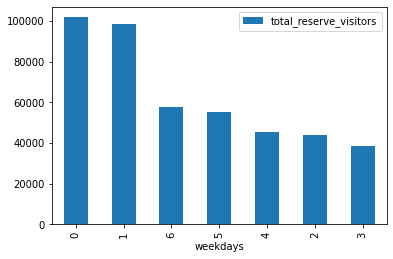

In [48]:
merge_air_store_genre6=merge_air_store_genre5[['reserve_visitors','weekdays']]
merge_air_store_genre7=merge_air_store_genre6.groupby(['weekdays']).sum().rename(columns={'reserve_visitors': 'total_reserve_visitors'}).sort_values('total_reserve_visitors', ascending=False)
merge_air_store_genre7.plot.bar()
#fri sat thr wed sun tue mon

In [49]:
#merge_air_store_genre8=merge_air_store_genre5[['reserve_visitors','holiday_flg']]
#sns.relplot(x='holiday_flg',y='reserve_visitors',data=merge_air_store_genre8,kind='bar')

In [50]:
#merge_air_store_genre8=merge_air_store_genre5[['reserve_visitors','holiday_flg']]
#merge_air_store_genre8.plot.barh(x='reserve_visitors', y='holiday_flg')

In [51]:
result1=merge_air_store_genre5[['reserve_visitors','latitude','longitude']]
result2=result1.groupby(['latitude','longitude']).sum().rename(columns={'reserve_visitors': 'total_resr_visitors_wrt_location'}).sort_values('total_resr_visitors_wrt_location', ascending=False)
result2['Location Rank'] = result2.total_resr_visitors_wrt_location.rank(method='dense',ascending=False).astype(int)
result2

,,total_resr_visitors_wrt_location,Location Rank
latitude,longitude,,
35.661777,139.704051,29897,1
34.386245,132.455018,29808,2
33.589216,130.392813,27221,3
43.770635,142.364819,22076,4
34.710895,137.725940,20166,5
...,...,...,...
35.708146,139.666288,10,69
35.711877,139.796697,7,70
34.688241,135.187254,6,71


In [52]:
result3=merge_air_store_genre5[['reserve_visitors','Asian','Bar/Cocktail','Cafe/Sweets','Creative cuisine','Dining bar','International cuisine','Italian/French','Izakaya','Japanese food','Karaoke/Party','Okonomiyaki/Monja/Teppanyaki','Other','Western food']]
result4=result3.groupby(['Asian','Bar/Cocktail','Cafe/Sweets','Creative cuisine','Dining bar','International cuisine','Italian/French','Izakaya','Japanese food','Karaoke/Party','Okonomiyaki/Monja/Teppanyaki','Other','Western food']).sum().rename(columns={'reserve_visitors': 'total_resr_visitors_wrt_cuisine'}).sort_values('total_resr_visitors_wrt_cuisine', ascending=False)
result4['Cuisine Rank'] = result4.total_resr_visitors_wrt_cuisine.rank(method='dense',ascending=False).astype(int)
result4

total_resr_visitors_wrt_cuisine  \
Asian Bar/Cocktail Cafe/Sweets Creative cuisine Dining bar International cuisine Italian/French Izakaya Japanese food Karaoke/Party Okonomiyaki/Monja/Teppanyaki Other Western food                                    
0     0            0           0                0          0                     0              1       0             0             0                            0     0                                      188157   
                                                                                 1              0       0             0             0                            0     0                                       77178   
                                                1          0                     0              0       0             0             0                            0     0                                       47460   
                                                0          0                     0              0       1             0             0                            0     0                                       41405   
                                                                                                        0             0             0                            0     0                                       27461   
                   1           0                0          0                     0              0       0             0             0                            0     0                                       14449   
                   0           0                0          0                     0              0       0             0             0                            0     1                                       13775   
                                                                                                                                    1                            0     0                                       12748   
      1            0           0                0          0                     0              0       0             0             0                            0     0                                        7282   
      0            0           1                0          0                     0              0       0             0             0                            0     0                                        6834   
                               0                0          0                     0              0       0             0             0                            1     0                                        2405   
                                                                                                                      1             0                            0     0                                        1565   
                                                           1                     0              0       0             0             0                            0     0                                          14   
1     0            0           0                0          0                     0              0       0             0             0                            0     0                                          12   

                                                                                                                                                                                     Cuisine Rank  
Asian Bar/Cocktail Cafe/Sweets Creative cuisine Dining bar International cuisine Italian/French Izakaya Japanese food Karaoke/Party Okonomiyaki/Monja/Teppanyaki Other Western food                
0     0            0           0                0          0                     0              1       0             0             0                            0     0                        1  
                                                                                 1              0       0             0             0   

In [53]:
result5 = pd.merge(merge_air_store_genre5,result2,how='left',on=['latitude','longitude'])
result5

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors,latitude,longitude,Asian,Bar/Cocktail,Cafe/Sweets,Creative cuisine,...,Japanese food,Karaoke/Party,Okonomiyaki/Monja/Teppanyaki,Other,Western food,visitors,holiday_flg,weekdays,total_resr_visitors_wrt_location,Location Rank
0,air_00a91d42b08b08d9,2016-01-14,2016-01-11,2,35.694003,139.753595,0,0,0,0,...,0,0,0,0,0,NaN,0,6,11042,15
1,air_00a91d42b08b08d9,2016-01-15,2016-01-09,4,35.694003,139.753595,0,0,0,0,...,0,0,0,0,0,NaN,0,0,11042,15
2,air_00a91d42b08b08d9,2016-01-16,2016-01-13,2,35.694003,139.753595,0,0,0,0,...,0,0,0,0,0,NaN,0,1,11042,15
3,air_00a91d42b08b08d9,2016-01-22,2016-01-19,2,35.694003,139.753595,0,0,0,0,...,0,0,0,0,0,NaN,0,0,11042,15
4,air_00a91d42b08b08d9,2016-01-29,2016-01-23,5,35.694003,139.753595,0,0,0,0,...,0,0,0,0,0,NaN,0,0,11042,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104797,air_fea5dc9594450608,2017-04-20,2017-04-17,6,34.710895,137.725940,0,0,0,0,...,0,0,0,1,0,NaN,0,6,20166,5
104798,air_fea5dc9594450608,2017-04-21,2017-04-03,6,34.710895,137.725940,0,0,0,0,...,0,0,0,1,0,NaN,0,0,20166,5
104799,air_fea5dc9594450608,2017-04-21,2017-04-12,2,34.710895,137.725940,0,0,0,0,...,0,0,0,1,0,NaN,0,0,20166,5
104800,air_fee8dcf4d619598e,2017-01-09,2016-12-27,2,34.695124,135.197852,0,0,0,0,...,0,0,0,0,0,17.0,1,3,14195,11


In [54]:
result6 = pd.merge(result5,result4,how='left',on=['Asian','Bar/Cocktail','Cafe/Sweets','Creative cuisine','Dining bar','International cuisine','Italian/French','Izakaya','Japanese food','Karaoke/Party','Okonomiyaki/Monja/Teppanyaki','Other','Western food'])
pd.set_option('display.max_columns', None)
result6

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors,latitude,longitude,Asian,Bar/Cocktail,Cafe/Sweets,Creative cuisine,Dining bar,International cuisine,Italian/French,Izakaya,Japanese food,Karaoke/Party,Okonomiyaki/Monja/Teppanyaki,Other,Western food,visitors,holiday_flg,weekdays,total_resr_visitors_wrt_location,Location Rank,total_resr_visitors_wrt_cuisine,Cuisine Rank
0,air_00a91d42b08b08d9,2016-01-14,2016-01-11,2,35.694003,139.753595,0,0,0,0,0,0,1,0,0,0,0,0,0,NaN,0,6,11042,15,77178,2
1,air_00a91d42b08b08d9,2016-01-15,2016-01-09,4,35.694003,139.753595,0,0,0,0,0,0,1,0,0,0,0,0,0,NaN,0,0,11042,15,77178,2
2,air_00a91d42b08b08d9,2016-01-16,2016-01-13,2,35.694003,139.753595,0,0,0,0,0,0,1,0,0,0,0,0,0,NaN,0,1,11042,15,77178,2
3,air_00a91d42b08b08d9,2016-01-22,2016-01-19,2,35.694003,139.753595,0,0,0,0,0,0,1,0,0,0,0,0,0,NaN,0,0,11042,15,77178,2
4,air_00a91d42b08b08d9,2016-01-29,2016-01-23,5,35.694003,139.753595,0,0,0,0,0,0,1,0,0,0,0,0,0,NaN,0,0,11042,15,77178,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104797,air_fea5dc9594450608,2017-04-20,2017-04-17,6,34.710895,137.725940,0,0,0,0,0,0,0,0,0,0,0,1,0,NaN,0,6,20166,5,2405,11
104798,air_fea5dc9594450608,2017-04-21,2017-04-03,6,34.710895,137.725940,0,0,0,0,0,0,0,0,0,0,0,1,0,NaN,0,0,20166,5,2405,11
104799,air_fea5dc9594450608,2017-04-21,2017-04-12,2,34.710895,137.725940,0,0,0,0,0,0,0,0,0,0,0,1,0,NaN,0,0,20166,5,2405,11
104800,air_fee8dcf4d619598e,2017-01-09,2016-12-27,2,34.695124,135.197852,0,0,0,0,0,0,1,0,0,0,0,0,0,17.0,1,3,14195,11,77178,2


In [55]:
result6.describe()

,reserve_visitors,latitude,longitude,Asian,Bar/Cocktail,Cafe/Sweets,Creative cuisine,Dining bar,International cuisine,Italian/French,Izakaya,Japanese food,Karaoke/Party,Okonomiyaki/Monja/Teppanyaki,Other,Western food,visitors,holiday_flg,weekdays,total_resr_visitors_wrt_location,Location Rank,total_resr_visitors_wrt_cuisine,Cuisine Rank
count,104802.000000,104802.000000,104802.000000,104802.000000,104802.000000,104802.000000,104802.000000,104802.000000,104802.000000,104802.00000,104802.000000,104802.000000,104802.000000,104802.000000,104802.000000,104802.000000,86896.000000,104802.000000,104802.000000,104802.000000,104802.000000,104802.000000,104802.000000
mean,4.205502,36.235230,137.089049,0.000010,0.015429,0.042194,0.013931,0.099760,0.000029,0.20575,0.374392,0.098548,0.001040,0.029780,0.006765,0.039780,32.368947,0.066545,2.495429,15383.804059,14.532929,98894.966031,2.977768
std,3.507711,2.978254,3.832959,0.003089,0.123253,0.201032,0.117205,0.299681,0.005350,0.40425,0.483968,0.298055,0.032233,0.169981,0.081972,0.195442,20.259612,0.249233,2.117975,8849.350876,13.101416,71910.261550,2.368928
min,1.000000,33.211967,130.348436,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,2.000000,1.000000,12.000000,1.000000
25%,2.000000,34.681261,134.685353,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000,0.000000,1.000000,8688.000000,5.000000,41405.000000,1.000000
50%,3.000000,35.629564,139.036327,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,29.000000,0.000000,2.000000,14195.000000,11.000000,77178.000000,2.000000
75%,5.000000,35.695694,139.759386,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,43.000000,0.000000,4.000000,20166.000000,20.000000,188157.000000,4.000000
max,24.000000,44.020632,144.273398,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,244.000000,1.000000,6.000000,29897.000000,72.000000,188157.000000,14.000000


In [56]:
pd.set_option('display.max_columns', None)
result6.columns

Index(['air_store_id', 'visit_datetime', 'reserve_datetime',
       'reserve_visitors', 'latitude', 'longitude', 'Asian', 'Bar/Cocktail',
       'Cafe/Sweets', 'Creative cuisine', 'Dining bar',
       'International cuisine', 'Italian/French', 'Izakaya', 'Japanese food',
       'Karaoke/Party', 'Okonomiyaki/Monja/Teppanyaki', 'Other',
       'Western food', 'visitors', 'holiday_flg', 'weekdays',
       'total_resr_visitors_wrt_location', 'Location Rank',
       'total_resr_visitors_wrt_cuisine', 'Cuisine Rank'],
      dtype='object')

In [57]:
result6['air_restaurant_id']=pd.factorize(result6.air_store_id)[0]

result17=result6[['visit_datetime', 'reserve_visitors', 'air_restaurant_id','air_store_id', 'holiday_flg', 'weekdays', 'Location Rank', 'Cuisine Rank']]
result18=result6[['visit_datetime', 'reserve_visitors', 'air_restaurant_id','air_store_id', 'holiday_flg', 'weekdays', 'Location Rank', 'Cuisine Rank','visitors']]

result7=result6[['visit_datetime', 'reserve_visitors', 'air_restaurant_id', 'holiday_flg', 'weekdays', 'Location Rank', 'Cuisine Rank','visitors']]
#result7 = result7.dropna()
result7

,visit_datetime,reserve_visitors,air_restaurant_id,holiday_flg,weekdays,Location Rank,Cuisine Rank,visitors
0,2016-01-14,2,0,0,6,15,2,NaN
1,2016-01-15,4,0,0,0,15,2,NaN
2,2016-01-16,2,0,0,1,15,2,NaN
3,2016-01-22,2,0,0,0,15,2,NaN
4,2016-01-29,5,0,0,0,15,2,NaN
...,...,...,...,...,...,...,...,...
104797,2017-04-20,6,331,0,6,5,11,NaN
104798,2017-04-21,6,331,0,0,5,11,NaN
104799,2017-04-21,2,331,0,0,5,11,NaN
104800,2017-01-09,2,332,1,3,11,2,17.0


In [58]:
result18.count()

visit_datetime       104802
reserve_visitors     104802
air_restaurant_id    104802
air_store_id         104802
holiday_flg          104802
weekdays             104802
Location Rank        104802
Cuisine Rank         104802
visitors              86896
dtype: int64

In [59]:
result17.count()

visit_datetime       104802
reserve_visitors     104802
air_restaurant_id    104802
air_store_id         104802
holiday_flg          104802
weekdays             104802
Location Rank        104802
Cuisine Rank         104802
dtype: int64

In [60]:
result117=result17[['air_store_id','visit_datetime','reserve_visitors']]
result217=result117.groupby(['air_store_id','visit_datetime']).sum().sort_values('reserve_visitors', ascending=False)
result217.count()

reserve_visitors    40627
dtype: int64

In [61]:
result118=result17[['air_store_id','reserve_visitors']]
result218=result118.groupby(['air_store_id']).mean().rename(columns={'reserve_visitors': 'mean_reserve_visitors_wrt_id'}).sort_values('mean_reserve_visitors_wrt_id', ascending=False).astype(int)
result218['mean_reserve_visitors_wrt_id'] = result218.mean_reserve_visitors_wrt_id.round()
result218.head()

,mean_reserve_visitors_wrt_id
air_store_id,
air_7514d90009613cd6,14
air_52a08ef3efdb4bb0,13
air_35512c42db0868da,12
air_10bbe8acd943d8f6,12
air_04341b588bde96cd,11


In [62]:
result7.describe()

,reserve_visitors,air_restaurant_id,holiday_flg,weekdays,Location Rank,Cuisine Rank,visitors
count,104802.000000,104802.000000,104802.000000,104802.000000,104802.000000,104802.000000,86896.000000
mean,4.205502,162.837618,0.066545,2.495429,14.532929,2.977768,32.368947
std,3.507711,98.782547,0.249233,2.117975,13.101416,2.368928,20.259612
min,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,2.000000,74.000000,0.000000,1.000000,5.000000,1.000000,18.000000
50%,3.000000,161.000000,0.000000,2.000000,11.000000,2.000000,29.000000
75%,5.000000,255.000000,0.000000,4.000000,20.000000,4.000000,43.000000
max,24.000000,332.000000,1.000000,6.000000,72.000000,14.000000,244.000000


In [63]:
result7.visitors.unique()

array([ nan,  35.,  29.,  42.,  11.,  36.,   5.,  19.,  47.,  53.,  24.,
        43.,   6.,  34.,  39.,   9.,  26.,  23.,  28.,  16.,  31.,  54.,
        33.,  27.,  14.,  30.,  20.,  17.,  37.,  18.,  99.,  15.,  44.,
        46.,   7.,  32.,  52.,  25.,  10.,   3.,   8.,   2.,  12.,   4.,
        13.,  57.,  41.,  89.,  60., 107.,  72.,  45.,  56.,  48., 119.,
        70.,  62.,  77.,  69.,  68.,  58.,  71.,  61.,  55.,  67.,  80.,
        59.,  38.,  66.,  75.,  85., 115.,  51.,  40.,  88.,  95.,  92.,
        76.,  82.,  49.,  63.,  83.,  93.,  50.,  22.,  21.,  81.,  73.,
        65.,  64.,  87., 244.,  74., 101.,  94.,  91.,  90.,   1.,  86.,
        96., 105., 139., 140., 120., 116., 144., 136., 100., 166., 131.,
       135., 130., 121., 109.,  78., 102.,  84.,  79.,  97., 106., 132.,
       111., 108., 118., 113., 183., 110., 114., 239., 117., 126., 103.,
       149.,  98., 207., 146., 168., 170., 129., 104., 181., 122., 216.,
       164., 199., 112., 124., 176., 189., 125., 13

In [64]:
trivialdata['id1'] = trivialdata['id']
trivialdata['air_store_id']=trivialdata['id1'].astype(str).str[0:20]
trivialdata['visit_datetime']=trivialdata['id1'].astype(str).str[21:31]
trivialdata1=trivialdata.drop(['id1'], axis=1)
trivialdata1

,id,visitors,air_store_id,visit_datetime
0,air_e3020992d5fe5dfd_2017-04-06,0,air_e3020992d5fe5dfd,2017-04-06
1,air_e3020992d5fe5dfd_2017-04-07,0,air_e3020992d5fe5dfd,2017-04-07
2,air_e3020992d5fe5dfd_2017-04-08,0,air_e3020992d5fe5dfd,2017-04-08
3,air_e3020992d5fe5dfd_2017-04-10,0,air_e3020992d5fe5dfd,2017-04-10
4,air_e3020992d5fe5dfd_2017-04-11,0,air_e3020992d5fe5dfd,2017-04-11
...,...,...,...,...
12430,air_4ce7b17062a1bf73_2017-04-18,0,air_4ce7b17062a1bf73,2017-04-18
12431,air_4ce7b17062a1bf73_2017-04-19,0,air_4ce7b17062a1bf73,2017-04-19
12432,air_4ce7b17062a1bf73_2017-04-20,0,air_4ce7b17062a1bf73,2017-04-20
12433,air_4ce7b17062a1bf73_2017-04-21,0,air_4ce7b17062a1bf73,2017-04-21


In [65]:
trivialdata1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12435 entries, 0 to 12434
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              12435 non-null  object
 1   visitors        12435 non-null  int64 
 2   air_store_id    12435 non-null  object
 3   visit_datetime  12435 non-null  object
dtypes: int64(1), object(3)
memory usage: 388.7+ KB


In [66]:
result17.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104802 entries, 0 to 104801
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   visit_datetime     104802 non-null  object
 1   reserve_visitors   104802 non-null  int64 
 2   air_restaurant_id  104802 non-null  int64 
 3   air_store_id       104802 non-null  object
 4   holiday_flg        104802 non-null  int64 
 5   weekdays           104802 non-null  int64 
 6   Location Rank      104802 non-null  int64 
 7   Cuisine Rank       104802 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 7.2+ MB


In [67]:
df_test = pd.merge(trivialdata1,air_stor_data ,how='left',on=['air_store_id'])
df_test.head()

,id,visitors,air_store_id,visit_datetime,air_genre_name,air_area_name,latitude,longitude
0,air_e3020992d5fe5dfd_2017-04-06,0,air_e3020992d5fe5dfd,2017-04-06,Italian/French,Tōkyō-to Chūō-ku Tsukiji,35.670651,139.771861
1,air_e3020992d5fe5dfd_2017-04-07,0,air_e3020992d5fe5dfd,2017-04-07,Italian/French,Tōkyō-to Chūō-ku Tsukiji,35.670651,139.771861
2,air_e3020992d5fe5dfd_2017-04-08,0,air_e3020992d5fe5dfd,2017-04-08,Italian/French,Tōkyō-to Chūō-ku Tsukiji,35.670651,139.771861
3,air_e3020992d5fe5dfd_2017-04-10,0,air_e3020992d5fe5dfd,2017-04-10,Italian/French,Tōkyō-to Chūō-ku Tsukiji,35.670651,139.771861
4,air_e3020992d5fe5dfd_2017-04-11,0,air_e3020992d5fe5dfd,2017-04-11,Italian/French,Tōkyō-to Chūō-ku Tsukiji,35.670651,139.771861


In [68]:
df_test.tail()

,id,visitors,air_store_id,visit_datetime,air_genre_name,air_area_name,latitude,longitude
12430,air_4ce7b17062a1bf73_2017-04-18,0,air_4ce7b17062a1bf73,2017-04-18,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
12431,air_4ce7b17062a1bf73_2017-04-19,0,air_4ce7b17062a1bf73,2017-04-19,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
12432,air_4ce7b17062a1bf73_2017-04-20,0,air_4ce7b17062a1bf73,2017-04-20,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
12433,air_4ce7b17062a1bf73_2017-04-21,0,air_4ce7b17062a1bf73,2017-04-21,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
12434,air_4ce7b17062a1bf73_2017-04-22,0,air_4ce7b17062a1bf73,2017-04-22,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599


In [69]:
df_test1 = pd.merge(df_test,resultt2,how='left',on=['latitude','longitude'])
df_test1.head()

,id,visitors,air_store_id,visit_datetime,air_genre_name,air_area_name,latitude,longitude,total_resr_visitors_wrt_location,Location Rank
0,air_e3020992d5fe5dfd_2017-04-06,0,air_e3020992d5fe5dfd,2017-04-06,Italian/French,Tōkyō-to Chūō-ku Tsukiji,35.670651,139.771861,176476,5
1,air_e3020992d5fe5dfd_2017-04-07,0,air_e3020992d5fe5dfd,2017-04-07,Italian/French,Tōkyō-to Chūō-ku Tsukiji,35.670651,139.771861,176476,5
2,air_e3020992d5fe5dfd_2017-04-08,0,air_e3020992d5fe5dfd,2017-04-08,Italian/French,Tōkyō-to Chūō-ku Tsukiji,35.670651,139.771861,176476,5
3,air_e3020992d5fe5dfd_2017-04-10,0,air_e3020992d5fe5dfd,2017-04-10,Italian/French,Tōkyō-to Chūō-ku Tsukiji,35.670651,139.771861,176476,5
4,air_e3020992d5fe5dfd_2017-04-11,0,air_e3020992d5fe5dfd,2017-04-11,Italian/French,Tōkyō-to Chūō-ku Tsukiji,35.670651,139.771861,176476,5


In [70]:
cuisine = {'air_genre_name': ['Asian','Bar/Cocktail','Cafe/Sweets','Creative cuisine','Dining bar','International cuisine','Italian/French','Izakaya','Japanese food','Karaoke/Party','Okonomiyaki/Monja/Teppanyaki','Other','Western food','Yakiniku/Korean food'],
'Cuisine Rank': [12, 6, 2, 10, 4, 14, 3, 1, 5, 13, 11, 7, 9, 8]}
cuisine_rank = pd.DataFrame(cuisine)
cuisine_rank.head()

,air_genre_name,Cuisine Rank
0,Asian,12
1,Bar/Cocktail,6
2,Cafe/Sweets,2
3,Creative cuisine,10
4,Dining bar,4


In [71]:
df_test2 = pd.merge(df_test1,resulttt2,how='left',on=['air_genre_name'])
df_test2.head()

,id,visitors,air_store_id,visit_datetime,air_genre_name,air_area_name,latitude,longitude,total_resr_visitors_wrt_location,Location Rank,total_resr_visitors_wrt_cuisine,Cuisine Rank
0,air_e3020992d5fe5dfd_2017-04-06,0,air_e3020992d5fe5dfd,2017-04-06,Italian/French,Tōkyō-to Chūō-ku Tsukiji,35.670651,139.771861,176476,5,642357,3
1,air_e3020992d5fe5dfd_2017-04-07,0,air_e3020992d5fe5dfd,2017-04-07,Italian/French,Tōkyō-to Chūō-ku Tsukiji,35.670651,139.771861,176476,5,642357,3
2,air_e3020992d5fe5dfd_2017-04-08,0,air_e3020992d5fe5dfd,2017-04-08,Italian/French,Tōkyō-to Chūō-ku Tsukiji,35.670651,139.771861,176476,5,642357,3
3,air_e3020992d5fe5dfd_2017-04-10,0,air_e3020992d5fe5dfd,2017-04-10,Italian/French,Tōkyō-to Chūō-ku Tsukiji,35.670651,139.771861,176476,5,642357,3
4,air_e3020992d5fe5dfd_2017-04-11,0,air_e3020992d5fe5dfd,2017-04-11,Italian/French,Tōkyō-to Chūō-ku Tsukiji,35.670651,139.771861,176476,5,642357,3


In [72]:
df_test3 = pd.merge(df_test2,dte_info_data_drp,how='left',left_on='visit_datetime',right_on='calendar_date')
df_test3.head()

,id,visitors,air_store_id,visit_datetime,air_genre_name,air_area_name,latitude,longitude,total_resr_visitors_wrt_location,Location Rank,total_resr_visitors_wrt_cuisine,Cuisine Rank,calendar_date,holiday_flg,weekdays
0,air_e3020992d5fe5dfd_2017-04-06,0,air_e3020992d5fe5dfd,2017-04-06,Italian/French,Tōkyō-to Chūō-ku Tsukiji,35.670651,139.771861,176476,5,642357,3,2017-04-06,0,6
1,air_e3020992d5fe5dfd_2017-04-07,0,air_e3020992d5fe5dfd,2017-04-07,Italian/French,Tōkyō-to Chūō-ku Tsukiji,35.670651,139.771861,176476,5,642357,3,2017-04-07,0,0
2,air_e3020992d5fe5dfd_2017-04-08,0,air_e3020992d5fe5dfd,2017-04-08,Italian/French,Tōkyō-to Chūō-ku Tsukiji,35.670651,139.771861,176476,5,642357,3,2017-04-08,0,1
3,air_e3020992d5fe5dfd_2017-04-10,0,air_e3020992d5fe5dfd,2017-04-10,Italian/French,Tōkyō-to Chūō-ku Tsukiji,35.670651,139.771861,176476,5,642357,3,2017-04-10,0,3
4,air_e3020992d5fe5dfd_2017-04-11,0,air_e3020992d5fe5dfd,2017-04-11,Italian/French,Tōkyō-to Chūō-ku Tsukiji,35.670651,139.771861,176476,5,642357,3,2017-04-11,0,4


In [73]:
df_test4=df_test3[['id','visitors','air_store_id','visit_datetime','Location Rank','Cuisine Rank','holiday_flg','weekdays','latitude','longitude']]
#df_test4['reserve_visitors']=df_test4['visitors']
df_test4.head()

,id,visitors,air_store_id,visit_datetime,Location Rank,Cuisine Rank,holiday_flg,weekdays,latitude,longitude
0,air_e3020992d5fe5dfd_2017-04-06,0,air_e3020992d5fe5dfd,2017-04-06,5,3,0,6,35.670651,139.771861
1,air_e3020992d5fe5dfd_2017-04-07,0,air_e3020992d5fe5dfd,2017-04-07,5,3,0,0,35.670651,139.771861
2,air_e3020992d5fe5dfd_2017-04-08,0,air_e3020992d5fe5dfd,2017-04-08,5,3,0,1,35.670651,139.771861
3,air_e3020992d5fe5dfd_2017-04-10,0,air_e3020992d5fe5dfd,2017-04-10,5,3,0,3,35.670651,139.771861
4,air_e3020992d5fe5dfd_2017-04-11,0,air_e3020992d5fe5dfd,2017-04-11,5,3,0,4,35.670651,139.771861


In [74]:
#df_test = df_test.dropna()
#result18 = result18.dropna()
#df_test4 = df_test4.fillna(-1)
df_test4

,id,visitors,air_store_id,visit_datetime,Location Rank,Cuisine Rank,holiday_flg,weekdays,latitude,longitude
0,air_e3020992d5fe5dfd_2017-04-06,0,air_e3020992d5fe5dfd,2017-04-06,5,3,0,6,35.670651,139.771861
1,air_e3020992d5fe5dfd_2017-04-07,0,air_e3020992d5fe5dfd,2017-04-07,5,3,0,0,35.670651,139.771861
2,air_e3020992d5fe5dfd_2017-04-08,0,air_e3020992d5fe5dfd,2017-04-08,5,3,0,1,35.670651,139.771861
3,air_e3020992d5fe5dfd_2017-04-10,0,air_e3020992d5fe5dfd,2017-04-10,5,3,0,3,35.670651,139.771861
4,air_e3020992d5fe5dfd_2017-04-11,0,air_e3020992d5fe5dfd,2017-04-11,5,3,0,4,35.670651,139.771861
...,...,...,...,...,...,...,...,...,...,...
12430,air_4ce7b17062a1bf73_2017-04-18,0,air_4ce7b17062a1bf73,2017-04-18,3,3,0,4,35.658068,139.751599
12431,air_4ce7b17062a1bf73_2017-04-19,0,air_4ce7b17062a1bf73,2017-04-19,3,3,0,5,35.658068,139.751599
12432,air_4ce7b17062a1bf73_2017-04-20,0,air_4ce7b17062a1bf73,2017-04-20,3,3,0,6,35.658068,139.751599
12433,air_4ce7b17062a1bf73_2017-04-21,0,air_4ce7b17062a1bf73,2017-04-21,3,3,0,0,35.658068,139.751599


In [75]:
df_test5 = pd.merge(df_test4,result217,how='left',on=['air_store_id','visit_datetime'])
df_test5.head()

,id,visitors,air_store_id,visit_datetime,Location Rank,Cuisine Rank,holiday_flg,weekdays,latitude,longitude,reserve_visitors
0,air_e3020992d5fe5dfd_2017-04-06,0,air_e3020992d5fe5dfd,2017-04-06,5,3,0,6,35.670651,139.771861,NaN
1,air_e3020992d5fe5dfd_2017-04-07,0,air_e3020992d5fe5dfd,2017-04-07,5,3,0,0,35.670651,139.771861,NaN
2,air_e3020992d5fe5dfd_2017-04-08,0,air_e3020992d5fe5dfd,2017-04-08,5,3,0,1,35.670651,139.771861,NaN
3,air_e3020992d5fe5dfd_2017-04-10,0,air_e3020992d5fe5dfd,2017-04-10,5,3,0,3,35.670651,139.771861,NaN
4,air_e3020992d5fe5dfd_2017-04-11,0,air_e3020992d5fe5dfd,2017-04-11,5,3,0,4,35.670651,139.771861,NaN


In [76]:
df_test5.count()

id                  12435
visitors            12435
air_store_id        12435
visit_datetime      12435
Location Rank       12435
Cuisine Rank        12435
holiday_flg         12435
weekdays            12435
latitude            12435
longitude           12435
reserve_visitors     2292
dtype: int64

In [77]:
df_train6 = pd.merge(df_train5,result217,how='left',on=['air_store_id','visit_datetime'])
df_train6.head()

,visitors,air_store_id,visit_datetime,Location Rank,Cuisine Rank,holiday_flg,weekdays,latitude,longitude,reserve_visitors
0,21,air_e3020992d5fe5dfd,2016-07-01,5,3,0,0,35.670651,139.771861,NaN
1,19,air_e3020992d5fe5dfd,2016-07-02,5,3,0,1,35.670651,139.771861,NaN
2,8,air_e3020992d5fe5dfd,2016-07-04,5,3,0,3,35.670651,139.771861,NaN
3,11,air_e3020992d5fe5dfd,2016-07-05,5,3,0,4,35.670651,139.771861,NaN
4,16,air_e3020992d5fe5dfd,2016-07-06,5,3,0,5,35.670651,139.771861,NaN


In [78]:
df_train6.count()

visitors            239673
air_store_id        239673
visit_datetime      239673
Location Rank       239673
Cuisine Rank        239673
holiday_flg         239673
weekdays            239673
latitude            239673
longitude           239673
reserve_visitors     32056
dtype: int64

In [79]:
##################

In [80]:
result17.head()

,visit_datetime,reserve_visitors,air_restaurant_id,air_store_id,holiday_flg,weekdays,Location Rank,Cuisine Rank
0,2016-01-14,2,0,air_00a91d42b08b08d9,0,6,15,2
1,2016-01-15,4,0,air_00a91d42b08b08d9,0,0,15,2
2,2016-01-16,2,0,air_00a91d42b08b08d9,0,1,15,2
3,2016-01-22,2,0,air_00a91d42b08b08d9,0,0,15,2
4,2016-01-29,5,0,air_00a91d42b08b08d9,0,0,15,2


In [81]:
df_test4.count()

id                12435
visitors          12435
air_store_id      12435
visit_datetime    12435
Location Rank     12435
Cuisine Rank      12435
holiday_flg       12435
weekdays          12435
latitude          12435
longitude         12435
dtype: int64

In [82]:
df_train6['reserve_visitors'] = df_train6['reserve_visitors'].fillna(0)
df_test5['reserve_visitors'] = df_test5['reserve_visitors'].fillna(0)
df_test5['Location Rank'] = df_test5['Location Rank'].fillna(109)

In [83]:
df_test5.info()
#,'latitude','longitude'

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12435 entries, 0 to 12434
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                12435 non-null  object 
 1   visitors          12435 non-null  int64  
 2   air_store_id      12435 non-null  object 
 3   visit_datetime    12435 non-null  object 
 4   Location Rank     12435 non-null  int64  
 5   Cuisine Rank      12435 non-null  int64  
 6   holiday_flg       12435 non-null  int64  
 7   weekdays          12435 non-null  int64  
 8   latitude          12435 non-null  float64
 9   longitude         12435 non-null  float64
 10  reserve_visitors  12435 non-null  float64
dtypes: float64(3), int64(5), object(3)
memory usage: 1.1+ MB


In [84]:
########################################################including air rest id

In [85]:
air_rest_id=air_stor_data[['air_store_id']]
air_rest_id['air_restaurant_id']=pd.factorize(air_rest_id.air_store_id)[0]
air_rest_id.head()


<ipython-input-85-aaf6edee4206>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  air_rest_id['air_restaurant_id']=pd.factorize(air_rest_id.air_store_id)[0]


,air_store_id,air_restaurant_id
0,air_0f0cdeee6c9bf3d7,0
1,air_7cc17a324ae5c7dc,1
2,air_fee8dcf4d619598e,2
3,air_a17f0778617c76e2,3
4,air_83db5aff8f50478e,4


In [86]:
df_train7 = pd.merge(df_train6,air_rest_id,how='left',on=['air_store_id'])
df_train7.head()

,visitors,air_store_id,visit_datetime,Location Rank,Cuisine Rank,holiday_flg,weekdays,latitude,longitude,reserve_visitors,air_restaurant_id
0,21,air_e3020992d5fe5dfd,2016-07-01,5,3,0,0,35.670651,139.771861,0.0,78
1,19,air_e3020992d5fe5dfd,2016-07-02,5,3,0,1,35.670651,139.771861,0.0,78
2,8,air_e3020992d5fe5dfd,2016-07-04,5,3,0,3,35.670651,139.771861,0.0,78
3,11,air_e3020992d5fe5dfd,2016-07-05,5,3,0,4,35.670651,139.771861,0.0,78
4,16,air_e3020992d5fe5dfd,2016-07-06,5,3,0,5,35.670651,139.771861,0.0,78


In [87]:
df_test6 = pd.merge(df_test5,air_rest_id,how='left',on=['air_store_id'])
df_test6.head()

,id,visitors,air_store_id,visit_datetime,Location Rank,Cuisine Rank,holiday_flg,weekdays,latitude,longitude,reserve_visitors,air_restaurant_id
0,air_e3020992d5fe5dfd_2017-04-06,0,air_e3020992d5fe5dfd,2017-04-06,5,3,0,6,35.670651,139.771861,0.0,78
1,air_e3020992d5fe5dfd_2017-04-07,0,air_e3020992d5fe5dfd,2017-04-07,5,3,0,0,35.670651,139.771861,0.0,78
2,air_e3020992d5fe5dfd_2017-04-08,0,air_e3020992d5fe5dfd,2017-04-08,5,3,0,1,35.670651,139.771861,0.0,78
3,air_e3020992d5fe5dfd_2017-04-10,0,air_e3020992d5fe5dfd,2017-04-10,5,3,0,3,35.670651,139.771861,0.0,78
4,air_e3020992d5fe5dfd_2017-04-11,0,air_e3020992d5fe5dfd,2017-04-11,5,3,0,4,35.670651,139.771861,0.0,78


In [88]:
################################################adding year, month, day as droping visit_datetime

In [89]:
df_train7['visit_datetime1'] = df_train7['visit_datetime']
df_train7['year']=df_train7['visit_datetime1'].astype(str).str[0:4]
df_train7['month']=df_train7['visit_datetime1'].astype(str).str[5:7]
df_train7['day']=df_train7['visit_datetime1'].astype(str).str[8:10]
df_train8=df_train7.drop(['visit_datetime1'], axis=1)
df_train8.head()

,visitors,air_store_id,visit_datetime,Location Rank,Cuisine Rank,holiday_flg,weekdays,latitude,longitude,reserve_visitors,air_restaurant_id,year,month,day
0,21,air_e3020992d5fe5dfd,2016-07-01,5,3,0,0,35.670651,139.771861,0.0,78,2016,07,01
1,19,air_e3020992d5fe5dfd,2016-07-02,5,3,0,1,35.670651,139.771861,0.0,78,2016,07,02
2,8,air_e3020992d5fe5dfd,2016-07-04,5,3,0,3,35.670651,139.771861,0.0,78,2016,07,04
3,11,air_e3020992d5fe5dfd,2016-07-05,5,3,0,4,35.670651,139.771861,0.0,78,2016,07,05
4,16,air_e3020992d5fe5dfd,2016-07-06,5,3,0,5,35.670651,139.771861,0.0,78,2016,07,06


In [90]:
df_train8['year'] = df_train8['year'].astype(np.int64)
df_train8['month'] = df_train8['month'].astype(np.int64)
df_train8['day'] = df_train8['day'].astype(np.int64)
df_train8.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 239673 entries, 0 to 239672
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   visitors           239673 non-null  int64  
 1   air_store_id       239673 non-null  object 
 2   visit_datetime     239673 non-null  object 
 3   Location Rank      239673 non-null  int64  
 4   Cuisine Rank       239673 non-null  int64  
 5   holiday_flg        239673 non-null  int64  
 6   weekdays           239673 non-null  int64  
 7   latitude           239673 non-null  float64
 8   longitude          239673 non-null  float64
 9   reserve_visitors   239673 non-null  float64
 10  air_restaurant_id  239673 non-null  int64  
 11  year               239673 non-null  int64  
 12  month              239673 non-null  int64  
 13  day                239673 non-null  int64  
dtypes: float64(3), int64(9), object(2)
memory usage: 27.4+ MB


In [91]:
df_train9 = pd.merge(df_train8,traindat1,how='left',on=['air_store_id'])
df_train9.head()

,visitors,air_store_id,visit_datetime,Location Rank,Cuisine Rank,holiday_flg,weekdays,latitude,longitude,reserve_visitors,air_restaurant_id,year,month,day,mean_visitors_wrt_id
0,21,air_e3020992d5fe5dfd,2016-07-01,5,3,0,0,35.670651,139.771861,0.0,78,2016,7,1,12
1,19,air_e3020992d5fe5dfd,2016-07-02,5,3,0,1,35.670651,139.771861,0.0,78,2016,7,2,12
2,8,air_e3020992d5fe5dfd,2016-07-04,5,3,0,3,35.670651,139.771861,0.0,78,2016,7,4,12
3,11,air_e3020992d5fe5dfd,2016-07-05,5,3,0,4,35.670651,139.771861,0.0,78,2016,7,5,12
4,16,air_e3020992d5fe5dfd,2016-07-06,5,3,0,5,35.670651,139.771861,0.0,78,2016,7,6,12


In [92]:
df_train10 = pd.merge(df_train9,result218,how='left',on=['air_store_id'])
df_train10.head()

,visitors,air_store_id,visit_datetime,Location Rank,Cuisine Rank,holiday_flg,weekdays,latitude,longitude,reserve_visitors,air_restaurant_id,year,month,day,mean_visitors_wrt_id,mean_reserve_visitors_wrt_id
0,21,air_e3020992d5fe5dfd,2016-07-01,5,3,0,0,35.670651,139.771861,0.0,78,2016,7,1,12,NaN
1,19,air_e3020992d5fe5dfd,2016-07-02,5,3,0,1,35.670651,139.771861,0.0,78,2016,7,2,12,NaN
2,8,air_e3020992d5fe5dfd,2016-07-04,5,3,0,3,35.670651,139.771861,0.0,78,2016,7,4,12,NaN
3,11,air_e3020992d5fe5dfd,2016-07-05,5,3,0,4,35.670651,139.771861,0.0,78,2016,7,5,12,NaN
4,16,air_e3020992d5fe5dfd,2016-07-06,5,3,0,5,35.670651,139.771861,0.0,78,2016,7,6,12,NaN


In [93]:
df_test6['visit_datetime1'] = df_test6['visit_datetime']
df_test6['year']=df_test6['visit_datetime1'].astype(str).str[0:4]
df_test6['month']=df_test6['visit_datetime1'].astype(str).str[5:7]
df_test6['day']=df_test6['visit_datetime1'].astype(str).str[8:10]
df_test7=df_test6.drop(['visit_datetime1'], axis=1)
df_test7.head()

,id,visitors,air_store_id,visit_datetime,Location Rank,Cuisine Rank,holiday_flg,weekdays,latitude,longitude,reserve_visitors,air_restaurant_id,year,month,day
0,air_e3020992d5fe5dfd_2017-04-06,0,air_e3020992d5fe5dfd,2017-04-06,5,3,0,6,35.670651,139.771861,0.0,78,2017,04,06
1,air_e3020992d5fe5dfd_2017-04-07,0,air_e3020992d5fe5dfd,2017-04-07,5,3,0,0,35.670651,139.771861,0.0,78,2017,04,07
2,air_e3020992d5fe5dfd_2017-04-08,0,air_e3020992d5fe5dfd,2017-04-08,5,3,0,1,35.670651,139.771861,0.0,78,2017,04,08
3,air_e3020992d5fe5dfd_2017-04-10,0,air_e3020992d5fe5dfd,2017-04-10,5,3,0,3,35.670651,139.771861,0.0,78,2017,04,10
4,air_e3020992d5fe5dfd_2017-04-11,0,air_e3020992d5fe5dfd,2017-04-11,5,3,0,4,35.670651,139.771861,0.0,78,2017,04,11


In [94]:
df_test7['year'] = df_test7['year'].astype(np.int64)
df_test7['month'] = df_test7['month'].astype(np.int64)
df_test7['day'] = df_test7['day'].astype(np.int64)
df_test7.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12435 entries, 0 to 12434
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 12435 non-null  object 
 1   visitors           12435 non-null  int64  
 2   air_store_id       12435 non-null  object 
 3   visit_datetime     12435 non-null  object 
 4   Location Rank      12435 non-null  int64  
 5   Cuisine Rank       12435 non-null  int64  
 6   holiday_flg        12435 non-null  int64  
 7   weekdays           12435 non-null  int64  
 8   latitude           12435 non-null  float64
 9   longitude          12435 non-null  float64
 10  reserve_visitors   12435 non-null  float64
 11  air_restaurant_id  12435 non-null  int64  
 12  year               12435 non-null  int64  
 13  month              12435 non-null  int64  
 14  day                12435 non-null  int64  
dtypes: float64(3), int64(9), object(3)
memory usage: 1.5+ MB


In [95]:
df_test8 = pd.merge(df_test7,traindat1,how='left',on=['air_store_id'])
df_test8.head()

,id,visitors,air_store_id,visit_datetime,Location Rank,Cuisine Rank,holiday_flg,weekdays,latitude,longitude,reserve_visitors,air_restaurant_id,year,month,day,mean_visitors_wrt_id
0,air_e3020992d5fe5dfd_2017-04-06,0,air_e3020992d5fe5dfd,2017-04-06,5,3,0,6,35.670651,139.771861,0.0,78,2017,4,6,12
1,air_e3020992d5fe5dfd_2017-04-07,0,air_e3020992d5fe5dfd,2017-04-07,5,3,0,0,35.670651,139.771861,0.0,78,2017,4,7,12
2,air_e3020992d5fe5dfd_2017-04-08,0,air_e3020992d5fe5dfd,2017-04-08,5,3,0,1,35.670651,139.771861,0.0,78,2017,4,8,12
3,air_e3020992d5fe5dfd_2017-04-10,0,air_e3020992d5fe5dfd,2017-04-10,5,3,0,3,35.670651,139.771861,0.0,78,2017,4,10,12
4,air_e3020992d5fe5dfd_2017-04-11,0,air_e3020992d5fe5dfd,2017-04-11,5,3,0,4,35.670651,139.771861,0.0,78,2017,4,11,12


In [96]:
df_test9 = pd.merge(df_test8,result218,how='left',on=['air_store_id'])
df_test9.head()

,id,visitors,air_store_id,visit_datetime,Location Rank,Cuisine Rank,holiday_flg,weekdays,latitude,longitude,reserve_visitors,air_restaurant_id,year,month,day,mean_visitors_wrt_id,mean_reserve_visitors_wrt_id
0,air_e3020992d5fe5dfd_2017-04-06,0,air_e3020992d5fe5dfd,2017-04-06,5,3,0,6,35.670651,139.771861,0.0,78,2017,4,6,12,NaN
1,air_e3020992d5fe5dfd_2017-04-07,0,air_e3020992d5fe5dfd,2017-04-07,5,3,0,0,35.670651,139.771861,0.0,78,2017,4,7,12,NaN
2,air_e3020992d5fe5dfd_2017-04-08,0,air_e3020992d5fe5dfd,2017-04-08,5,3,0,1,35.670651,139.771861,0.0,78,2017,4,8,12,NaN
3,air_e3020992d5fe5dfd_2017-04-10,0,air_e3020992d5fe5dfd,2017-04-10,5,3,0,3,35.670651,139.771861,0.0,78,2017,4,10,12,NaN
4,air_e3020992d5fe5dfd_2017-04-11,0,air_e3020992d5fe5dfd,2017-04-11,5,3,0,4,35.670651,139.771861,0.0,78,2017,4,11,12,NaN


In [97]:
df_train10['mean_reserve_visitors_wrt_id'] = df_train10['mean_reserve_visitors_wrt_id'].fillna(0).astype(np.int64)
df_test9['mean_reserve_visitors_wrt_id'] = df_test9['mean_reserve_visitors_wrt_id'].fillna(0).astype(np.int64)

In [98]:
train=df_train10[['visit_datetime','air_store_id','holiday_flg','weekdays','Location Rank','Cuisine Rank','visitors','reserve_visitors','latitude','longitude','air_restaurant_id','year','month','day','mean_visitors_wrt_id','mean_reserve_visitors_wrt_id']]
test=df_test9[['id','visit_datetime','air_store_id','holiday_flg','weekdays','Location Rank','Cuisine Rank','visitors','reserve_visitors','latitude','longitude','air_restaurant_id','year','month','day','mean_visitors_wrt_id','mean_reserve_visitors_wrt_id']]

In [99]:
train['visitors'] = train['visitors'].astype(np.int64)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 239673 entries, 0 to 239672
Data columns (total 16 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   visit_datetime                239673 non-null  object 
 1   air_store_id                  239673 non-null  object 
 2   holiday_flg                   239673 non-null  int64  
 3   weekdays                      239673 non-null  int64  
 4   Location Rank                 239673 non-null  int64  
 5   Cuisine Rank                  239673 non-null  int64  
 6   visitors                      239673 non-null  int64  
 7   reserve_visitors              239673 non-null  float64
 8   latitude                      239673 non-null  float64
 9   longitude                     239673 non-null  float64
 10  air_restaurant_id             239673 non-null  int64  
 11  year                          239673 non-null  int64  
 12  month                         239673 non-nul

In [100]:
#train.visitors.unique()

In [101]:
train['reserve_visitors'] = train['reserve_visitors'].astype(np.int64)
test['reserve_visitors'] = test['reserve_visitors'].astype(np.int64)

In [102]:
train.head()

,visit_datetime,air_store_id,holiday_flg,weekdays,Location Rank,Cuisine Rank,visitors,reserve_visitors,latitude,longitude,air_restaurant_id,year,month,day,mean_visitors_wrt_id,mean_reserve_visitors_wrt_id
0,2016-07-01,air_e3020992d5fe5dfd,0,0,5,3,21,0,35.670651,139.771861,78,2016,7,1,12,0
1,2016-07-02,air_e3020992d5fe5dfd,0,1,5,3,19,0,35.670651,139.771861,78,2016,7,2,12,0
2,2016-07-04,air_e3020992d5fe5dfd,0,3,5,3,8,0,35.670651,139.771861,78,2016,7,4,12,0
3,2016-07-05,air_e3020992d5fe5dfd,0,4,5,3,11,0,35.670651,139.771861,78,2016,7,5,12,0
4,2016-07-06,air_e3020992d5fe5dfd,0,5,5,3,16,0,35.670651,139.771861,78,2016,7,6,12,0


In [103]:
test.tail()

,id,visit_datetime,air_store_id,holiday_flg,weekdays,Location Rank,Cuisine Rank,visitors,reserve_visitors,latitude,longitude,air_restaurant_id,year,month,day,mean_visitors_wrt_id,mean_reserve_visitors_wrt_id
12430,air_4ce7b17062a1bf73_2017-04-18,2017-04-18,air_4ce7b17062a1bf73,0,4,3,3,0,8,35.658068,139.751599,15,2017,4,18,7,5
12431,air_4ce7b17062a1bf73_2017-04-19,2017-04-19,air_4ce7b17062a1bf73,0,5,3,3,0,0,35.658068,139.751599,15,2017,4,19,7,5
12432,air_4ce7b17062a1bf73_2017-04-20,2017-04-20,air_4ce7b17062a1bf73,0,6,3,3,0,0,35.658068,139.751599,15,2017,4,20,7,5
12433,air_4ce7b17062a1bf73_2017-04-21,2017-04-21,air_4ce7b17062a1bf73,0,0,3,3,0,0,35.658068,139.751599,15,2017,4,21,7,5
12434,air_4ce7b17062a1bf73_2017-04-22,2017-04-22,air_4ce7b17062a1bf73,0,1,3,3,0,0,35.658068,139.751599,15,2017,4,22,7,5


In [104]:
print('Binding to float32')

for c, dtype in zip(train.columns, train.dtypes):
    if dtype == np.float64:
        train[c] = train[c].astype(np.float32)

for c, dtype in zip(test.columns, test.dtypes):
    if dtype == np.float64:
        test[c] = test[c].astype(np.float32)

train_x = train.drop(['air_store_id', 'visit_datetime', 'visitors'], axis=1)
train_y = np.log1p(train['visitors'].values)
print(train_x.shape, train_y.shape)
test_x = test.drop(['id', 'air_store_id', 'visit_datetime', 'visitors'], axis=1)


Binding to float32
(239673, 13) (239673,)


In [105]:
train_x.head()

,holiday_flg,weekdays,Location Rank,Cuisine Rank,reserve_visitors,latitude,longitude,air_restaurant_id,year,month,day,mean_visitors_wrt_id,mean_reserve_visitors_wrt_id
0,0,0,5,3,0,35.67065,139.771866,78,2016,7,1,12,0
1,0,1,5,3,0,35.67065,139.771866,78,2016,7,2,12,0
2,0,3,5,3,0,35.67065,139.771866,78,2016,7,4,12,0
3,0,4,5,3,0,35.67065,139.771866,78,2016,7,5,12,0
4,0,5,5,3,0,35.67065,139.771866,78,2016,7,6,12,0


In [106]:
train_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 239673 entries, 0 to 239672
Data columns (total 13 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   holiday_flg                   239673 non-null  int64  
 1   weekdays                      239673 non-null  int64  
 2   Location Rank                 239673 non-null  int64  
 3   Cuisine Rank                  239673 non-null  int64  
 4   reserve_visitors              239673 non-null  int64  
 5   latitude                      239673 non-null  float32
 6   longitude                     239673 non-null  float32
 7   air_restaurant_id             239673 non-null  int64  
 8   year                          239673 non-null  int64  
 9   month                         239673 non-null  int64  
 10  day                           239673 non-null  int64  
 11  mean_visitors_wrt_id          239673 non-null  int64  
 12  mean_reserve_visitors_wrt_id  239673 non-nul

In [107]:
test_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12435 entries, 0 to 12434
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   holiday_flg                   12435 non-null  int64  
 1   weekdays                      12435 non-null  int64  
 2   Location Rank                 12435 non-null  int64  
 3   Cuisine Rank                  12435 non-null  int64  
 4   reserve_visitors              12435 non-null  int64  
 5   latitude                      12435 non-null  float32
 6   longitude                     12435 non-null  float32
 7   air_restaurant_id             12435 non-null  int64  
 8   year                          12435 non-null  int64  
 9   month                         12435 non-null  int64  
 10  day                           12435 non-null  int64  
 11  mean_visitors_wrt_id          12435 non-null  int64  
 12  mean_reserve_visitors_wrt_id  12435 non-null  int64  
dtypes

In [108]:
train_y

array([3.09104245, 2.99573227, 2.19722458, ..., 2.30258509, 2.48490665,
       1.94591015])

# KNeighborsRegressor Model

In [109]:
from sklearn.neighbors import KNeighborsRegressor

In [110]:
train_x = train
test = test

In [111]:
train_x1 = train_x.drop(['air_store_id', 'visitors'], axis=1)
train_x1.set_index('visit_datetime',inplace=True)

In [112]:
train_x1 = train_x1.drop(['year','month', 'day'], axis=1)

In [113]:
train_y1 = train_x['visitors']
train_x1

,holiday_flg,weekdays,Location Rank,Cuisine Rank,reserve_visitors,latitude,longitude,air_restaurant_id,mean_visitors_wrt_id,mean_reserve_visitors_wrt_id
visit_datetime,,,,,,,,,,
2016-07-01,0,0,5,3,0,35.67065,139.771866,78,12,0
2016-07-02,0,1,5,3,0,35.67065,139.771866,78,12,0
2016-07-04,0,3,5,3,0,35.67065,139.771866,78,12,0
2016-07-05,0,4,5,3,0,35.67065,139.771866,78,12,0
2016-07-06,0,5,5,3,0,35.67065,139.771866,78,12,0
...,...,...,...,...,...,...,...,...,...,...
2017-03-30,0,6,3,3,0,35.65807,139.751602,15,7,5
2017-03-31,0,0,3,3,0,35.65807,139.751602,15,7,5
2017-04-01,0,1,3,3,0,35.65807,139.751602,15,7,5


In [114]:
knr = KNeighborsRegressor(20)
knr.fit(train_x1, train_y1)

KNeighborsRegressor(n_neighbors=20)

In [115]:
test.tail()

,id,visit_datetime,air_store_id,holiday_flg,weekdays,Location Rank,Cuisine Rank,visitors,reserve_visitors,latitude,longitude,air_restaurant_id,year,month,day,mean_visitors_wrt_id,mean_reserve_visitors_wrt_id
12430,air_4ce7b17062a1bf73_2017-04-18,2017-04-18,air_4ce7b17062a1bf73,0,4,3,3,0,8,35.65807,139.751602,15,2017,4,18,7,5
12431,air_4ce7b17062a1bf73_2017-04-19,2017-04-19,air_4ce7b17062a1bf73,0,5,3,3,0,0,35.65807,139.751602,15,2017,4,19,7,5
12432,air_4ce7b17062a1bf73_2017-04-20,2017-04-20,air_4ce7b17062a1bf73,0,6,3,3,0,0,35.65807,139.751602,15,2017,4,20,7,5
12433,air_4ce7b17062a1bf73_2017-04-21,2017-04-21,air_4ce7b17062a1bf73,0,0,3,3,0,0,35.65807,139.751602,15,2017,4,21,7,5
12434,air_4ce7b17062a1bf73_2017-04-22,2017-04-22,air_4ce7b17062a1bf73,0,1,3,3,0,0,35.65807,139.751602,15,2017,4,22,7,5


In [116]:
test_x1 = test.drop(['id', 'air_store_id', "visitors"], axis=1)
test_x1.set_index('visit_datetime',inplace=True)

In [117]:
test_x1 = test_x1.drop(['year','month', 'day'], axis=1)

In [118]:
test_x1.head()

,holiday_flg,weekdays,Location Rank,Cuisine Rank,reserve_visitors,latitude,longitude,air_restaurant_id,mean_visitors_wrt_id,mean_reserve_visitors_wrt_id
visit_datetime,,,,,,,,,,
2017-04-06,0,6,5,3,0,35.67065,139.771866,78,12,0
2017-04-07,0,0,5,3,0,35.67065,139.771866,78,12,0
2017-04-08,0,1,5,3,0,35.67065,139.771866,78,12,0
2017-04-10,0,3,5,3,0,35.67065,139.771866,78,12,0
2017-04-11,0,4,5,3,0,35.67065,139.771866,78,12,0


In [119]:
predicted_visitors = pd.DataFrame(columns = ['predicted_visitors'])

In [120]:
test_x2= np.array(test_x1[:])

In [121]:
for x in test_x2:
    test1 = x.reshape(1,-1)
    pr = knr.predict(test1)
    df = {"predicted_visitors": pr[0]}
    predicted_visitors = predicted_visitors.append(df,  ignore_index = True)    

In [122]:
test_x1.reset_index(inplace=True)
test_x1

,visit_datetime,holiday_flg,weekdays,Location Rank,Cuisine Rank,reserve_visitors,latitude,longitude,air_restaurant_id,mean_visitors_wrt_id,mean_reserve_visitors_wrt_id
0,2017-04-06,0,6,5,3,0,35.67065,139.771866,78,12,0
1,2017-04-07,0,0,5,3,0,35.67065,139.771866,78,12,0
2,2017-04-08,0,1,5,3,0,35.67065,139.771866,78,12,0
3,2017-04-10,0,3,5,3,0,35.67065,139.771866,78,12,0
4,2017-04-11,0,4,5,3,0,35.67065,139.771866,78,12,0
...,...,...,...,...,...,...,...,...,...,...,...
12430,2017-04-18,0,4,3,3,8,35.65807,139.751602,15,7,5
12431,2017-04-19,0,5,3,3,0,35.65807,139.751602,15,7,5
12432,2017-04-20,0,6,3,3,0,35.65807,139.751602,15,7,5
12433,2017-04-21,0,0,3,3,0,35.65807,139.751602,15,7,5


In [123]:
test3 = test.join(predicted_visitors)
final_result = test3[['id', 'predicted_visitors']]
final_result = final_result.rename(columns = {"predicted_visitors":"visitors"}) 

In [124]:
final_result

,id,visitors
0,air_e3020992d5fe5dfd_2017-04-06,12.90
1,air_e3020992d5fe5dfd_2017-04-07,17.10
2,air_e3020992d5fe5dfd_2017-04-08,14.95
3,air_e3020992d5fe5dfd_2017-04-10,10.55
4,air_e3020992d5fe5dfd_2017-04-11,12.00
...,...,...
12430,air_4ce7b17062a1bf73_2017-04-18,10.65
12431,air_4ce7b17062a1bf73_2017-04-19,7.95
12432,air_4ce7b17062a1bf73_2017-04-20,7.25
12433,air_4ce7b17062a1bf73_2017-04-21,7.55


In [125]:
final_result.to_csv(r'24_Nov_KNeighborsRegressor.csv', index = False, header=True)

In [126]:
knr.score(train_x1, train_y1)

0.5645852890313539

# Random Forest Regression Model

In [127]:
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor

In [128]:
from sklearn.ensemble import RandomForestRegressor

In [129]:
print('Binding to float32')

for c, dtype in zip(train.columns, train.dtypes):
    if dtype == np.float64:
        train[c] = train[c].astype(np.float32)

for c, dtype in zip(test.columns, test.dtypes):
    if dtype == np.float64:
        test[c] = test[c].astype(np.float32)

train_x = train.drop(['air_store_id', 'visit_datetime', 'visitors'], axis=1)
train_y = np.log1p(train['visitors'].values)
print(train_x.shape, train_y.shape)
test_x = test.drop(['id', 'air_store_id', 'visit_datetime', 'visitors'], axis=1)


Binding to float32
(239673, 13) (239673,)


In [130]:
rf = RandomForestRegressor(max_depth = 45, n_estimators = 60, n_jobs=-1)
rf.fit(train_x,train_y)

RandomForestRegressor(max_depth=45, n_estimators=60, n_jobs=-1)

In [131]:
rf.score(train_x, train_y)

0.9418276491796485

In [132]:
predict_y = rf.predict(test_x)

In [133]:
test['visitors'] = np.expm1(predict_y)

In [134]:
test[['id', 'visitors']].to_csv('rf_submission.csv', index=False, float_format=None)

In [135]:
rf_submission2 = pd.read_csv("rf_submission.csv")
rf_submission2.head()

,id,visitors
0,air_e3020992d5fe5dfd_2017-04-06,8.589403
1,air_e3020992d5fe5dfd_2017-04-07,14.677009
2,air_e3020992d5fe5dfd_2017-04-08,11.356764
3,air_e3020992d5fe5dfd_2017-04-10,12.523649
4,air_e3020992d5fe5dfd_2017-04-11,10.754559


In [136]:
rf_submission2.describe()

,visitors
count,12435.000000
mean,19.945473
std,14.600035
min,1.000000
25%,8.944239
50%,16.305355
75%,27.084320
max,161.473501


# Decision Tree Regression Model

In [137]:
dt = DecisionTreeRegressor(max_depth = 40, min_samples_split = 10)
dt.fit(train_x,train_y)

DecisionTreeRegressor(max_depth=40, min_samples_split=10)

In [138]:
dt.score(train_x, train_y)

0.808129830407703

In [139]:
predict_y1 = dt.predict(test_x)

In [140]:
test['visitors'] = np.expm1(predict_y1)

In [141]:
test[['id', 'visitors']].to_csv('dt_submission.csv', index=False, float_format=None)

In [142]:
dt_submission = pd.read_csv("dt_submission.csv")
dt_submission.head()

,id,visitors
0,air_e3020992d5fe5dfd_2017-04-06,11.505736
1,air_e3020992d5fe5dfd_2017-04-07,16.401055
2,air_e3020992d5fe5dfd_2017-04-08,7.918910
3,air_e3020992d5fe5dfd_2017-04-10,14.522340
4,air_e3020992d5fe5dfd_2017-04-11,14.482511


# XGBoost Model

In [143]:
boost_params = {'eval_metric': 'rmsle'}
xgb0 = xgb.XGBRegressor(
    max_depth=8,
    learning_rate=0.009,
    n_estimators=10000,
    objective='reg:linear',
    gamma=0,
    min_child_weight=1,
    subsample=1,
    colsample_bytree=1,
    scale_pos_weight=1,
    seed=27,
    **boost_params)
# .3  .61035 98.9
# .1  .54766 93.9 ..... 
# .05 .51 88  .............
# .03 .509 .83
# .01 .501 73 
# .009 
# .005 .505 68 

In [ ]:
xgb0.fit(train_x, train_y)

[22:54:25] WARNING: ../src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
xgb0.score(train_x, train_y)
#0.6289018265712556 #0.6300314779509224 with lati longi #0.7246957907932454 with yr mon dy 0.7225800331746912 with test correct join
#0.7372569009111782 with mean visitors

#.7400 with mean reserev vist and .01 lr
#.728 with mean reserev vist and .009 lr

In [ ]:
predict_y = xgb0.predict(test_x)

In [ ]:
test['visitors'] = np.expm1(predict_y)

In [ ]:
test[['id', 'visitors']].to_csv('xgb17_submission.csv', index=False, float_format=None)

In [ ]:
xgb_submission = pd.read_csv("xgb17_submission.csv")
xgb_submission.head()

In [ ]:
xgb_submission['visitors'] = xgb_submission.visitors.round()
xgb_submission.head()

In [ ]:
xgb_submission.count()